## 证照识别V4.0

####  操作：
1. 识别二维码

***
1. A4纸边缘顶点提取
2. A4纸矫正
3. 数字按顺序分割
    1. 图像二值化
    2. 基于垂直方向直方图，把原图进行行分割为多张行子图，每张行子图包含一行数字（可能有多列）
    3. 基于水平方向直方图，把行子图进行列分割为多张真子图，每张真子图包含单行单列的数字
    4. 对每张子图，进行扩张(dilation)，并进行断裂字符修复
    5. 对每张子图，用连通区域标记方法(connected-component_labeling algorithm)从左到右分割数字
    6. 对每张子图，存储单个数字以及一个图像名列表文本
    7. 对每张子图，识别对应的文字

4. 参考: https://blog.csdn.net/qq_33000225/article/details/73123880
5. 参考: https://blog.csdn.net/OnceMonkey/article/details/79996687



### 操作步骤:

    1、先对输入图像进行灰度化处理，再按一定比例下采样（即对图像插值压缩）

    2、利用上一次作业的Canny算法提取边缘（得到的边缘有噪点且不完整）

    3、对ImageSpace做HoughSpace（极坐标）变换，并做voting投票（矩阵累加）

    4、对累加矩阵取最大的一些值，得到边缘直线的斜率、截距，并画出边缘直线

    5、求每两条直线之间交点，并累计该交点的直线交叉次数

    6、取交叉次数最多的4个点，即为A4纸的四个顶点

    7、把顶点坐标上采样并放回原图，最后4个顶点之间连线，形成边缘



In [10]:
import cv2
import numpy as np
import pyzbar.pyzbar as pyzbar
import pytesseract
import matplotlib.pyplot as plt
# from torch import nn
# import torch
import imutils
from imutils.perspective import four_point_transform
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files (x86)/Tesseract-OCR/tesseract.exe"

In [250]:
# img_url = r"F:\PYcode\Coding\ic\license\source_img\4.jpg"


img = cv2.imread(img_url)
img.shape


(1592, 1044, 3)

In [251]:
# 识别二维码程序
def QR_image(img):
    identification = []
    inforesout = pyzbar.decode(img)
    for dadada in inforesout:
        identification.append(dadada.data.decode("utf-8"))
#             print(dadada.data.decode("utf-8"))
    return identification

In [252]:
img = cv2.imread(img_url, 0)
message = QR_image(img)

In [253]:
message

['统一社会信用代码：91510100MA6AQPBR8H\r\n企业注册号：510109001600056\r\n名称：成都西辰易通科技有限公司\r\n登记机关：成都市高新工商行政管理局\r\n登记日期：2019-01-28\r\n企业信用信息公示系统网址：http://gsxt.scaic.gov.cn  http://gsxt.cdcredit.gov.cn']

In [254]:
# 四边形矫正
def change_size(image):
    # 读取图片
    width1, height1 = image.shape[1], image.shape[0]
    # 转灰色
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 高斯滤波
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # 自适应二值化方法
    blurred=cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,51,2)
#     blurred=cv2.copyMakeBorder(blurred,5,5,5,5,cv2.BORDER_CONSTANT,value=(255,255,255))
    # 找到边框
    edged = cv2.Canny(blurred, 10, 100)
    # 找到矩阵
    cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    docCnt = None

    if len(cnts) > 0:
        # 将轮廓按大小降序排序
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
        # 对排序后的轮廓循环处理
        for c in cnts:
            # 获取近似的轮廓
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            # 如果近似轮廓有四个顶点，那么就认为找到了图片
            if len(approx) == 4:
                docCnt = approx
                break
                
    newimage = image.copy()
    for i in docCnt:
        #circle函数为在图像上作图，新建了一个图像用来演示四角选取
        cv2.circle(newimage, (i[0][0],i[0][1]), 10, (255, 0, 0), -1)
        
    paper = four_point_transform(image, docCnt.reshape(4, 2))
    warped = four_point_transform(gray, docCnt.reshape(4, 2))

    # 对灰度图应用二值化算法
    thresh = cv2.adaptiveThreshold(warped,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,53,2)
    #重塑可能用到的图像
#     thresh = cv2.resize(thresh, (width1, height1), cv2.INTER_LANCZOS4)
    paper = cv2.resize(paper, (width1, height1), cv2.INTER_LANCZOS4)
#     warped = cv2.resize(warped, (width1, height1), cv2.INTER_LANCZOS4)
    
#     paper = cv2.copyMakeBorder(paper,100,100,100,100,cv2.BORDER_CONSTANT, value=(255,255,255))
#     paper = paper[50:height1-50, 50:width1-50]
    cv2.imwrite("resoutlicence.jpg", paper)
    paper = cv2.cvtColor(paper, cv2.COLOR_RGB2GRAY)
    return paper

In [366]:
#  从上倒下分隔图片
def getImageHorizontalAndVerticalSum(image):
    ImageThre = image
    ret, ImageThre=cv2.threshold(ImageThre, 125,255, cv2.THRESH_BINARY_INV)
    rows, cols = ImageThre.shape
    horsum = []
    versum = []
    for i in range(cols):
        val = np.array(ImageThre[:, i]).sum()
        horsum.append(val)
#         print(val)

    for i in range(rows):
        val = np.array(ImageThre[i, :]).sum()
        versum.append(val)
        # print(val)
    return horsum,versum    
#     return versum

 
#这个函数我们最终需要找到一个区间表示字符的竖直分布情况
def getVerticalCharPosition(versum):
    result=[] #用来保存找到的结果：位置，区间大小
    i = 0
    while i< len(versum):
        if(versum[i] > max(versum)/15):
            j=1 #代表这个区间的大小
            sumver = versum[i] #代表这整个区间的像素和是多少
            while(versum[i+j] > max(versum)/15):
                sumver = sumver + versum[i + j]
                j = j + 1     
                if i+j == len(versum):
                    break
            if j > 10 and sumver > 4000: 
                result.append([i, j])

            i = i + j + 1 #跳过这整个不为0的区间，开始寻找下一个区间
        i = i + 1
    return result
 
# #这个函数我们最终需要找到四个区间表示字符的水平分布情况
# 水平切割暂时不需要 
# def getHorizontalCharPosition(horsum):
#     result = []  # 用来保存找到的结果：位置，区间大小
#     i = 0 
#     while  i < len(horsum):
#         if(versum[i] != 0):
#             j = 1 #代表这个区间的大小
#             sumver = versum[i] #代表这整个区间的像素和是多少
#             while(versum[i+j] != 0):
#                 sumver = sumver + versum[i+j]
#                 j = j + 1     
#                 if i+j == len(versum):
#                     break
#             if j > 60 and sumver > 4000: 
#                 result.append([i, j])

#             i = i+j+1 #跳过这整个不为0的区间，开始寻找下一个区间
#         i = i+1
#     return result
 
def getHorizontalCharPosition(horsum):
    result = []  # 用来保存找到的结果：位置，区间大小
    i = 0 
    while  i < len(horsum):
        if(horsum[i] > 2000):
            result.append(i)
         #跳过这整个不为0的区间，开始寻找下一个区间
        i = i+1
    return min(result), max(result)
#这个函数返回所有可能是字符的图片区域
#这个函数返回所有可能是字符的图片区域
# def getCharImages(verticalCharPosition,horizontalCharPosition,image):
#     charImages = []
#     #v,h:[position,width]
#     for v in verticalCharPosition:
#         for h in horizontalCharPosition:
#             charImages.append(image[v[0] : v[0]+v[1], h[0] : h[0]+h[1]])
#     return charImages 

def getCharImages(verticalCharPosition, image):
    weight, height = image.shape[:2]
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    charImages = []
    #v,h:[position,width]
    for v in verticalCharPosition:
        charImages.append(image[max(v[0]-20, 0): min(v[0]+v[1]+20, height),0: weight])
    return charImages 


In [367]:
img_url = r"F:/PYcode/Coding/ic/license/source_img/5.jpg"

In [368]:
img = cv2.imread(img_url, cv2.IMREAD_COLOR)
image = change_size(img)
image.shape

(4608, 3456)

In [369]:
horsum,versum = getImageHorizontalAndVerticalSum(image)

In [370]:
verticalCharPosition = getVerticalCharPosition(versum)

In [371]:
catimg = getCharImages(verticalCharPosition, image)

In [323]:
verticalCharPosition

[[128, 196],
 [355, 121],
 [525, 13],
 [582, 25],
 [671, 25],
 [724, 26],
 [777, 25],
 [829, 24],
 [881, 26],
 [932, 25],
 [985, 25],
 [1035, 50],
 [1090, 23],
 [1118, 23],
 [1280, 223],
 [1505, 25],
 [1557, 19]]

In [372]:
lis = []
for i in range(len(catimg)):
    h = catimg[i].shape[0]
    horsumv, versumv = getImageHorizontalAndVerticalSum(catimg[i])
    s, e = getHorizontalCharPosition(horsumv)
    cv2.imwrite('%s.jpg'%(i), catimg[i][0: h, max(s-50,0): e+50])
    lis.append(''.join(pytesseract.image_to_string(catimg[i][0:h, max(s-50,0): e+50], lang="chi_sim").split()))

AttributeError: 'NoneType' object has no attribute 'shape'

In [339]:
lis

['命r子-.′入一',
 '',
 '纳一社会信用代砌91510100MA6AQPBKRS8H',
 '丨成都西辰易通科技有限八耐',
 'As“有限资任公司(的然人投资或控股的法人犯资)',
 '一成都高新区科园三路4号1栋12尿2命',
 ':人“张义',
 'laˇ祉卅资杨“(人民币)善佰万元',
 '肌7口刘2019年1月23日',
 '“s5\\厄兰【氏2019年1月23日至永久',
 "'′3行围仑舞机状件技术升友、技术咨询、技术转让、技术服务;申丁产品的心2巳设计、开发及技术服务;批发计算机及玛酮件、申一史:“门伯设发",
 '(个吾无统厂描电侠发射及卫星地丽接收设备》,借恺系绒伊成月失',
 '。《伏芳须经批佩的项目,经相关邱门批准后方可开厂纲魅江书),',
 '',
 '',
 '',
 'T',
 '',
 '',
 ',芸吴genoniqnigoqinoiguaniiiiolnignloy刑吴命CNFangprlerao[',
 '中协人民共和国国家工寇行政算埕心局相剧',
 '连页',
 '']

In [340]:
import re
def get_start():
    for index in range(len(lis)):
        pattern = re.compile('\d{6}')
        if pattern.search(lis[index]):
            ss = index
    return ss
start = get_start()

In [34]:
import cv2
image = cv2.imread(r"F:\PYcode\Coding\ic\license\3.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image,(0, 0), fx=0.8, fy=0.8, interpolation=cv2.INTER_NEAREST)
_, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
opened2 = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel,iterations=2)     #开运算1

In [35]:
pytesseract.image_to_string(img, lang="chi_sim")

'名 称 成 都 西 辰 易 通 科 技 有 限 公 闭'

In [19]:


kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))              #定义矩形结构元素(核大小为3效果好)
TOPHAT_img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)     #顶帽运算
BLACKHAT_img = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel) #黒帽运算

bitwiseXor_gray = cv2.bitwise_xor(img,TOPHAT_img)

closed1 = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel,iterations=1)    #闭运算1
closed2 = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel,iterations=3)    #闭运算2
opened1 = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel,iterations=1)     #开运算1
opened2 = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel,iterations=2)     #开运算1


In [383]:
cv2.imwrite("12.jpg",img)
cv2.imwrite("13.jpg",TOPHAT_img)
cv2.imwrite("14.jpg",BLACKHAT_img)
cv2.imwrite("15.jpg",bitwiseXor_gray)

True

In [20]:

#显示如下腐蚀后的图像
cv2.imshow("closed1", closed1)
cv2.imshow("closed2", closed2)
cv2.imshow("opened1", opened1)
cv2.imshow("opened2", opened2)


cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
lis1 = lis[start:start+8]
lis1

In [ ]:
import re
pattern = re.compile(ur'(\d{6})')
str = u''
print(pattern.search(str))

In [13]:
for i in range(len(catimg)):
    cv2.imshow(str(i),catimg[i]) 
#     res = pytesseract.image_to_string(catimg[i], lang="chi_sim")
#     cv2.imwrite("img_out\b%s.jpg"%(i), catimg[i])
#     cv2.imwrite("img_out\q%s.jpg"%(i), img1[ y:(y+h), x:(x+w)])
#     print(res)
    
# cv2.imshow('raw image',image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 统一社会信用代码：91510100MA63DEFJ00\r\n企业注册号：510109001599590\r\n
# 名称：成都西辰易督科技有限公司\r\n登记机关：成都市高新工商行政管

In [276]:
versum.count(0)


4

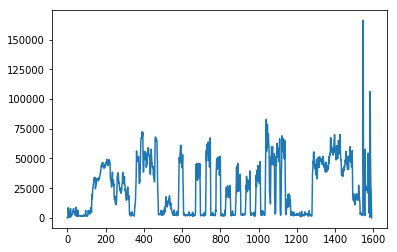

In [312]:
#输出函数曲线图，这里输出了水平方向和竖直方向上的像素情况，可以很明显的知道数字的分布
rows, cols = image.shape
# X = np.arange(0,cols,1)
# plt.plot(X,versum)
X = np.arange(0,rows,1)
plt.plot(X,versum)
plt.show()

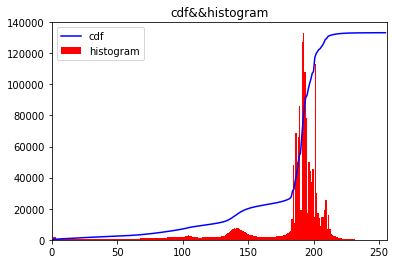

In [303]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread(img_url, 0)

hist, bins = np.histogram(img.flatten(), 256, [0,256])

cdf = hist.cumsum()
cdf_normalized = cdf*float(hist.max())/cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title("cdf&&histogram")
plt.show()

In [80]:
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m-cdf_m.min()) * 255 / (cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m, 0).astype('uint8')

In [81]:
img2 = cdf[img]

In [83]:
img = cv.imread(img_url, 0)
equ = cv.equalizeHist(img)
res = np.hstack((img, equ)) # 并排叠加图片
cv.imwrite('res.png', res)

True

In [84]:
import numpy as np
import cv2 as cv

img = cv.imread(img_url, 0)

# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)

cv.imwrite('clahe_2.jpg', cl1)

True